In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import scipy as scp
import openpyxl
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sktime as skt
import explainerdashboard as exd

# supress this warning
pd.options.mode.chained_assignment = None

print({pkg.__name__:pkg.__version__ for pkg in [pd, np, scp, sklearn, openpyxl, sns, matplotlib, skt]})

{'pandas': '1.3.4', 'numpy': '1.21.6', 'scipy': '1.8.1', 'sklearn': '1.1.1', 'openpyxl': '3.0.9', 'seaborn': '0.11.1', 'matplotlib': '3.4.3', 'sktime': '0.12.0'}


In [2]:
#importing sys
import sys
  
# adding src to the system path
sys.path.insert(0, '../src')

### Traditional ML using summary stats

In [3]:
# this function creates the summary statistics of each series
from ml_pipeline.featureset  import make_summary_stats_input

In [4]:
# load the data
train = pd.read_csv('../input/train/data.csv',parse_dates=['Time']).set_index('Time')
test = pd.read_csv('../input/test/data.csv',parse_dates=['Time']).set_index('Time')

# dictionary to store all the data cuts we will create
data_dict = {'stat':{}, '1col':{}, 'ts':{}}

In [5]:
train.head(3)

,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Status
Time,,,,,,,,,,,,
2020-01-01 00:00:00,31.11716,74.1715,72.0,16.81,76.0,0.791225,203.793426,0.582975,799.101683,7.149643,15.842287,0.0
2020-01-01 00:01:00,31.11716,74.1715,72.0,16.81,76.0,0.791225,203.793426,0.582975,799.101683,7.149643,15.842287,0.0
2020-01-01 00:02:00,32.08894,74.0803,72.0,17.08,76.0,0.803988,204.411886,0.575500,834.897700,7.089729,15.739743,0.0


In [6]:
train.shape

(20160, 12)

In [7]:
# this function wraps together several functions we've seen before
from ml_pipeline.model import processing_pipeline

# we take a subset of our data for computation speed
# important that we always use sme arguments for train and test 
data_dict['stat']['X_train'], data_dict['stat']['y_train'] = processing_pipeline(
            train[-3100:-2900],
            window_kwargs = {'window_length':30, 'step_length':1, 'fh':0},
            feature_func = make_summary_stats_input)

data_dict['stat']['X_test'], data_dict['stat']['y_test'] = processing_pipeline(
            test[4200:4400],
            window_kwargs = {'window_length':30, 'step_length':1, 'fh':0},
            feature_func = make_summary_stats_input)

In [8]:
# train our model using a logistic regression
from ml_pipeline.model import train_traditional_model
model_stats = train_traditional_model(
                        X = data_dict['stat']['X_train'].values, 
                        y = data_dict['stat']['y_train'].values)

### 1-dimensional time series classifier framework

In [9]:
# this function arranges X values into a single dataframe (where each cell is a series)
from ml_pipeline.featureset import make_series_input

In [10]:
# this function wraps together several functions we've seen before
from ml_pipeline.model import processing_pipeline

In [11]:
# note we have changed feature_func, and we are also only selecting 1 column from the data
data_dict['1col']['X_train'], data_dict['1col']['y_train'] = processing_pipeline(
            train[-3100:-2900][['Temperature','Status']],
            window_kwargs = {'window_length':30, 'step_length':1, 'fh':0},
            feature_func = make_series_input,
            add_first_diffs = False)

data_dict['1col']['X_test'], data_dict['1col']['y_test'] = processing_pipeline(
            test[4200:4400][['Temperature','Status']],
            window_kwargs = {'window_length':30, 'step_length':1, 'fh':0},
            feature_func = make_series_input,
            add_first_diffs = False)

In [12]:
data_dict['1col']['X_train'].shape

(171, 1)

In [13]:
data_dict['1col']['X_train'].head(3)

,Temperature
Time,
2020-01-12 20:49:00,0 36.72205 1 36.12795 2 36.01693 3...
2020-01-12 20:50:00,0 36.12795 1 36.01693 2 36.76770 3...
2020-01-12 20:51:00,0 36.01693 1 36.76770 2 36.65917 3...


In [14]:
type(data_dict['1col']['X_train'].iloc[0,0])

pandas.core.series.Series

In [15]:
data_dict['1col']['X_train'].iloc[0,0].head(4)

0    36.72205
1    36.12795
2    36.01693
3    36.76770
Name: Temperature, dtype: float64

In [16]:
# this function trains a series classifier
from ml_pipeline.model import train_series_model

# train our model
model_1col = train_series_model(
                X = data_dict['1col']['X_train'],
                y = data_dict['1col']['y_train']
                )

### Multi-dimensional time series classifier framework

In [17]:
# note we have all columns now, and we are adding first differences also
data_dict['ts']['X_train'], data_dict['ts']['y_train'] = processing_pipeline(
            train[-3100:-2900],
            window_kwargs = {'window_length':30, 'step_length':1, 'fh':0},
            feature_func = make_series_input,
            add_first_diffs = True)

data_dict['ts']['X_test'], data_dict['ts']['y_test'] = processing_pipeline(
            test[4200:4400],
            window_kwargs = {'window_length':30, 'step_length':1, 'fh':0},
            feature_func = make_series_input,
            add_first_diffs = True)

In [18]:
data_dict['ts']['X_train'].head(1)

,Temperature,Humidity,RPM,Vibrations,Pressure,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Temperature_diff,Humidity_diff,RPM_diff,Vibrations_diff,Pressure_diff,Sensor2_diff,Sensor3_diff,Sensor4_diff,Sensor5_diff,Sensor6_diff
Time,,,,,,,,,,,,,,,,,,,,
2020-01-12 20:49:00,0 36.72205 1 36.12795 2 36.01693 3...,0 64.798200 1 65.263900 2 65.09390...,0 72.0 1 72.0 2 72.0 3 72.0 4 ...,0 71.08 1 70.62 2 67.29 3 70.8...,0 74.0 1 75.0 2 74.0 3 74.0 4 ...,0 198.820489 1 198.497974 2 198.70...,0 0.688679 1 0.712169 2 0.726049 3...,0 923.115900 1 927.568950 2 909.53...,0 7.115405 1 7.138228 2 7.092582 3...,0 15.654291 1 15.765376 2 15.73120...,0 0.00000 1 -0.59410 2 -0.11102 3 ...,0 0.000000 1 0.465700 2 -0.170000 3...,0 0.0 1 0.0 2 0.0 3 0.0 4 ...,0 0.00 1 -0.46 2 -3.33 3 3.56 4 ...,0 0.0 1 1.0 2 -1.0 3 0.0 4 ...,0 0.000000 1 -0.322514 2 0.210460 3...,0 0.000000 1 0.023490 2 0.013880 3...,0 0.000000 1 4.453050 2 -18.03456...,0 0.000000 1 0.022823 2 -0.045646 3...,0 0.000000 1 0.111085 2 -0.034174 3...


In [19]:
# this function will train a multi series ensemble
from ml_pipeline.model import train_multiseries_model
model_ts = train_multiseries_model(
                X = data_dict['ts']['X_train'],
                y = data_dict['ts']['y_train'])

In [20]:
# this trains one estimator for each column
model_ts.estimators_

[('knn_0', KNeighborsTimeSeriesClassifier(), [0]),
 ('knn_1', KNeighborsTimeSeriesClassifier(), [1]),
 ('knn_2', KNeighborsTimeSeriesClassifier(), [2]),
 ('knn_3', KNeighborsTimeSeriesClassifier(), [3]),
 ('knn_4', KNeighborsTimeSeriesClassifier(), [4]),
 ('knn_5', KNeighborsTimeSeriesClassifier(), [5]),
 ('knn_6', KNeighborsTimeSeriesClassifier(), [6]),
 ('knn_7', KNeighborsTimeSeriesClassifier(), [7]),
 ('knn_8', KNeighborsTimeSeriesClassifier(), [8]),
 ('knn_9', KNeighborsTimeSeriesClassifier(), [9]),
 ('knn_10', KNeighborsTimeSeriesClassifier(), [10]),
 ('knn_11', KNeighborsTimeSeriesClassifier(), [11]),
 ('knn_12', KNeighborsTimeSeriesClassifier(), [12]),
 ('knn_13', KNeighborsTimeSeriesClassifier(), [13]),
 ('knn_14', KNeighborsTimeSeriesClassifier(), [14]),
 ('knn_15', KNeighborsTimeSeriesClassifier(), [15]),
 ('knn_16', KNeighborsTimeSeriesClassifier(), [16]),
 ('knn_17', KNeighborsTimeSeriesClassifier(), [17]),
 ('knn_18', KNeighborsTimeSeriesClassifier(), [18]),
 ('knn_19', K

In [21]:
# we can recover the individual estimators, e.g. for the second column ('RPM')
model_column_2 = model_ts.estimators_[2][1]

# we can then predict using just this columns (we have to select the correct column from the X dataframe)
model_column_2.predict(data_dict['ts']['X_train'][['RPM']])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [22]:
# let see how performance varies
accuracy = []

# iterate through each column
for idx, name in enumerate(data_dict['ts']['X_test'].columns):

    # get the estimator for that column
    model_column_idx = model_ts.estimators_[idx][1]

    # get accuracy for that column
    accuracy.append((model_column_idx.predict(data_dict['ts']['X_test'][[name]]) == data_dict['ts']['y_test']).mean())

accuracy = pd.Series(data=accuracy, index=data_dict['ts']['X_test'].columns)

In [23]:
# We can see a clear variation in performance
# We could potentially performance of our ensemble by only using high accuracy columns 
accuracy.sort_values(ascending=False)

Sensor5             0.994152
RPM                 0.988304
Sensor6             0.988304
Sensor6_diff        0.959064
Temperature         0.935673
Vibrations          0.912281
Sensor2_diff        0.894737
Vibrations_diff     0.777778
Sensor2             0.719298
Sensor5_diff        0.719298
Pressure_diff       0.707602
RPM_diff            0.631579
Temperature_diff    0.625731
Humidity_diff       0.619883
Sensor4             0.520468
Sensor4_diff        0.508772
Sensor3_diff        0.327485
Sensor3             0.292398
Pressure            0.292398
Humidity            0.251462
dtype: float64

### Evaluating our model results

In [24]:
# our model returns a probability of class assignment
model_stats.predict_proba(data_dict['stat']['X_test'].values.astype(np.float32))[50:51]

array([[0.18052786, 0.81947214]])

In [25]:
# this function creates a dashboard app to quickly check results
# after running this code open the html file it saved in /output
# we can see the ideal thershold is higher than 50%
from ml_pipeline.model import create_explainer_dashboard
create_explainer_dashboard(model_stats, 
                data_dict['stat']['X_test'], 
                data_dict['stat']['y_test'], 
                save_path='../output/dashboard.html',
                )

splitting pipeline...
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Note: model_output='probability' is currently not supported for linear classifiers models with shap. So defaulting to model_output='logodds' If you really need probability outputs use shap='kernel' instead.
Note: shap values for shap='linear' get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.LinearExplainer(model, X)...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating depend

In [26]:
# function to get a set of results 
from ml_pipeline.model import test_model

# one set at default threshold
result_50 = test_model(data_dict['stat']['X_test'].values.astype(np.float32), 
                    data_dict['stat']['y_test'].values.astype(np.float32), 
                    model_stats, 
                    threshold=0.50)

# another at the higher threshold
result_95 = test_model(data_dict['stat']['X_test'].values.astype(np.float32), 
                    data_dict['stat']['y_test'].values.astype(np.float32), 
                    model_stats, 
                    threshold=0.95)

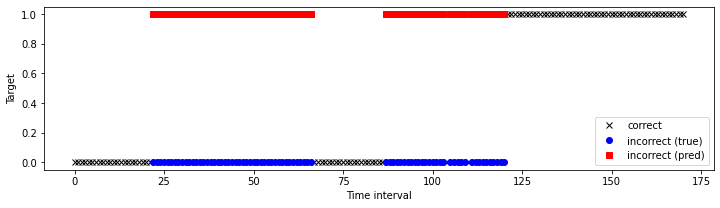

In [27]:
# function to visualise results
from ml_pipeline.model import plot_model_result

# we can now visualise on the time series what is ocurring on the time series for both
plot_model_result(result_50)

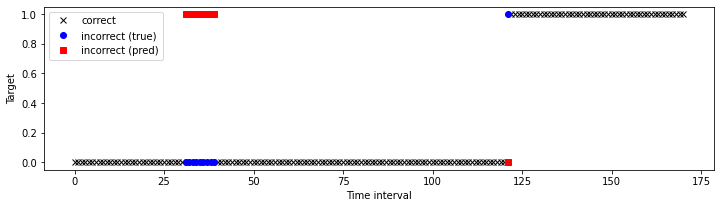

In [28]:
# zoom in on the relevant part
plot_model_result(result_95)

In [29]:
# our time series classifier is distance based and only return exact 1 or 0 
# there there is no point seeting a probability threshold
model_1col.predict_proba(data_dict['1col']['X_test'].iloc[:1])

array([[1., 0.]])

Accuracy =  0.935672514619883


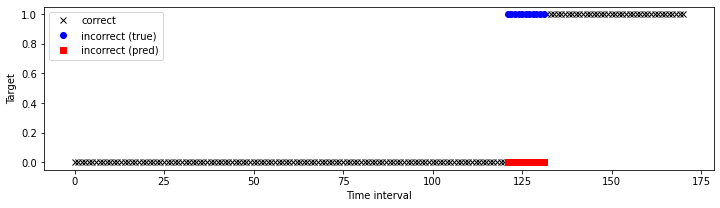

In [30]:
# we can see how our single series classifer compares 
result = test_model(data_dict['1col']['X_test'], 
                    data_dict['1col']['y_test'].values,
                    model_1col, 
                    threshold=0.50)

print('Accuracy = ', (result['residual']==0).mean())

# we can now visualise on the time series what is ocurring on the time series for both
plot_model_result(result)

Accuracy =  0.9707602339181286


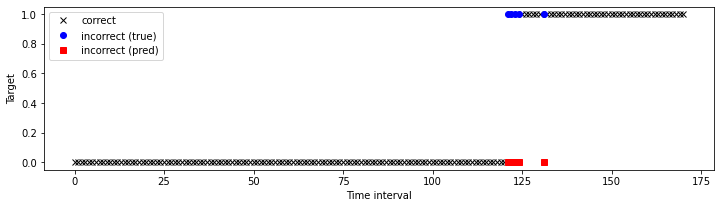

In [31]:
# and how our multie series classifer compares 
result = test_model(data_dict['ts']['X_test'], 
                    data_dict['ts']['y_test'].values,
                    model_ts, 
                    threshold=0.50)

print('Accuracy = ', (result['residual']==0).mean())

# we can now visualise on the time series what is ocurring on the time series for both
plot_model_result(result)

### Impact of window size and lag

- we will repeat our summary stat classifier, but this time reduce the window length to see if accuracy changes
- our first clasifier was length 30, we will reudce to 15
- we can also try switching lag to 5, so we are now predicting into the future, to see how accuracy changes

#### i) window = 15

In [32]:
# repeate this process but with lower window length
data_dict['stat15'] = {}

data_dict['stat15']['X_train'], data_dict['stat15']['y_train'] = processing_pipeline(
            train[-3100:-2900],
            window_kwargs = {'window_length':15, 'step_length':1, 'fh':0},
            feature_func = make_summary_stats_input )

data_dict['stat15']['X_test'], data_dict['stat15']['y_test'] = processing_pipeline(
            test[4200:4400],
            window_kwargs = {'window_length':15, 'step_length':1, 'fh':0},
            feature_func = make_summary_stats_input)

# train model 
model_stats_15 = train_traditional_model(
    data_dict['stat15']['X_train'].values.astype(float),
    data_dict['stat15']['y_train'].values.astype(float)
    )

Accuracy =  0.989247311827957


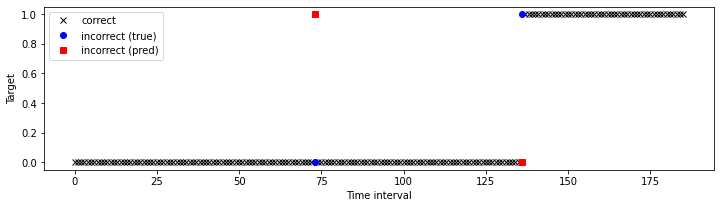

In [33]:
# we can see how our single series classifer compares 
result = test_model(data_dict['stat15']['X_test'], 
                    data_dict['stat15']['y_test'].values,
                    model_stats_15, 
                    threshold=0.50)

print('Accuracy = ', (result['residual']==0).mean())

# we can now visualise on the time series what is ocurring on the time series for both
plot_model_result(result)

#### ii) lag = 5

In [34]:
# repeate this process but with lower window length
data_dict['statlag5'] = {}

data_dict['statlag5']['X_train'], data_dict['statlag5']['y_train'] = processing_pipeline(
            train[-3100:-2900],
            window_kwargs = {'window_length':30, 'step_length':1, 'fh':5},
            feature_func = make_summary_stats_input )

data_dict['statlag5']['X_test'], data_dict['statlag5']['y_test'] = processing_pipeline(
            test[4200:4400],
            window_kwargs = {'window_length':30, 'step_length':1, 'fh':5},
            feature_func = make_summary_stats_input)

# train model 
model_statlag5 = train_traditional_model(
    data_dict['statlag5']['X_train'].values.astype(float),
    data_dict['statlag5']['y_train'].values.astype(float)
    )

Accuracy =  0.4397590361445783


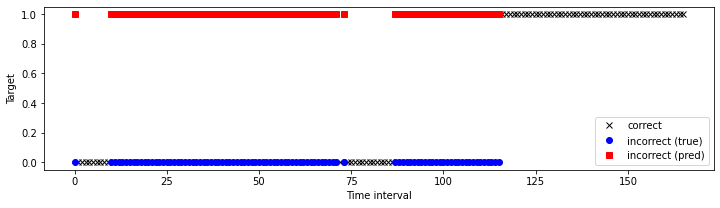

In [35]:
# we can see how our single series classifer compares 
result = test_model(data_dict['statlag5']['X_test'], 
                    data_dict['statlag5']['y_test'].values,
                    model_statlag5, 
                    threshold=0.50)

print('Accuracy = ', (result['residual']==0).mean())

# we can now visualise on the time series what is ocurring on the time series for both
plot_model_result(result)

#### Run main engine

In [36]:
#!python engine.py